In [1]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import geopandas as gpd

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

# 1. Data Loading

In [2]:
boundary_path = r'C:/Data Analysis/부평구 상권분석/data/전처리 파일/부평구 도로_5181/도로 데이터/5. 기초구역별 도로데이터/집계전'
basis_area_path = r'C:/Data Analysis/부평구 상권분석/data/전처리 파일/부평구_기초구역_5181'
near_boundary_road_data = gpd.read_file(boundary_path+'/기초구역별_도로데이터_경계인접_5181.shp')
not_near_boundary_road_data = gpd.read_file(boundary_path+'/기초구역별_도로데이터_경계미인접_5181.shp')
basis_area_data = gpd.read_file(basis_area_path+'/부평구_기초구역_5181.shp')

In [3]:
near_boundary_road_data.columns

Index(['BAS_AR', 'BAS_ID', 'BAS_MGT_SN', 'CTP_KOR_NM', 'MVMN_DE', 'MVMN_RESN',
       'NTFC_DE', 'OPERT_DE', 'SIG_CD', 'SIG_KOR_NM', 'ALWNC_DE', 'ALWNC_RESN',
       'BSI_INT', 'ENG_RN', 'MVMN_DE_2', 'MVMN_RESN_', 'MVM_RES_CD',
       'NTFC_DE_2', 'OPERT_DE_2', 'RBP_CN', 'RDS_DPN_SE', 'RDS_MAN_NO',
       'REP_CN', 'RN', 'RN_CD', 'ROAD_BT', 'ROAD_LT', 'ROA_CLS_SE', 'SIG_CD_2',
       'WDR_RD_CD', 'ROAD_LT_CU', 'center_x', 'center_y', 'geometry'],
      dtype='object')

In [4]:
# 불필요한 컬럼 삭제
essential_col = ['BAS_ID','BAS_AR','ROAD_BT','ROAD_LT','ROAD_LT_CU','geometry']

use_data1 = near_boundary_road_data[essential_col]
use_data2 = not_near_boundary_road_data[essential_col]

# 2. 결측치 제거

In [5]:
display(use_data1.isnull().sum())
display(use_data2.isnull().sum())

BAS_ID        0
BAS_AR        0
ROAD_BT       2
ROAD_LT       2
ROAD_LT_CU    2
geometry      0
dtype: int64

BAS_ID        0
BAS_AR        0
ROAD_BT       7
ROAD_LT       7
ROAD_LT_CU    7
geometry      0
dtype: int64

In [6]:
use_data1 = use_data1.dropna()
use_data2 = use_data2.dropna()

In [7]:
# 2에는 '-nan(ind)'가 없다. 따라서 1에서만 drop을 진행한다.
use_data1.drop(use_data1.loc[use_data1['ROAD_LT_CU']=='-nan(ind)'].index,axis=0,inplace=True)
# use_data2.drop(use_data1.loc[use_data2['ROAD_LT_CU']=='-nan(ind)'].index,axis=0,inplace=True)

# 3. 도로율 컬럼 생성


In [8]:
use_data1['ROAD_LT_CU'] = use_data1.loc[:,'ROAD_LT_CU'].astype('float')
use_data2['ROAD_LT_CU'] = use_data2.loc[:,'ROAD_LT_CU'].astype('float')

In [9]:
# 도로 길이와 폭은 m단위이므로, 도로의 넓이를 구한다음 10만으로 나누어준다.
use_data1['ROAD_AREA'] = (use_data1['ROAD_BT'] * use_data1['ROAD_LT_CU']) / 1000000
use_data2['ROAD_AREA'] = (use_data2['ROAD_BT'] * use_data2['ROAD_LT_CU']) / 1000000

In [10]:
# 경계인접도로에 모든 기초구역이 포함되어 있는가?
set(basis_area_data['BAS_ID'])- set(use_data1['BAS_ID'].unique())

{'21417', '21460'}

In [11]:
# 위의 기초구역은 그대로 BAS_AR을 사용하면 될것같다.
# 기존의 BAS_AR에 경계인접도로의 넓이를 더해준다.
use_data1['BAS_AR'] += use_data1['ROAD_AREA']

In [12]:
# 임시로 기초구역 넓이(+도로 넓이) 저장
TEMP_BAS_DATA = use_data1[['BAS_ID','BAS_AR']]

In [13]:
use_data = pd.concat([use_data1,use_data2])
use_data

,BAS_ID,BAS_AR,ROAD_BT,ROAD_LT,ROAD_LT_CU,geometry,ROAD_AREA
0,21459,2.649139,4.0,75.000,75.309,"POLYGON ((176641.304 442645.152, 176647.527 44...",0.000301
1,21459,2.648906,3.0,23.000,22.798,"POLYGON ((176641.304 442645.152, 176647.527 44...",0.000068
2,21384,0.158624,30.0,249.442,80.385,"POLYGON ((174332.882 443549.806, 174341.717 44...",0.002412
3,21384,0.156395,30.0,332.271,6.100,"POLYGON ((174332.882 443549.806, 174341.717 44...",0.000183
4,21384,0.156437,30.0,332.271,7.501,"POLYGON ((174332.882 443549.806, 174341.717 44...",0.000225
...,...,...,...,...,...,...,...
3004,21432,0.249155,3.0,48.000,47.513,"POLYGON ((174941.445 442603.951, 174999.172 44...",0.000143
3005,21432,0.249155,4.0,45.000,45.456,"POLYGON ((174941.445 442603.951, 174999.172 44...",0.000182
3006,21432,0.249155,5.0,52.000,51.927,"POLYGON ((174941.445 442603.951, 174999.172 44...",0.000260
3007,21432,0.249155,3.0,451.000,451.072,"POLYGON ((174941.445 442603.951, 174999.172 44...",0.001353


In [14]:
basis_area_data.sort_values(by='BAS_ID',axis=0,inplace=True)
basis_area = basis_area_data[['BAS_ID','BAS_AR','geometry']]
basis_area

,BAS_ID,BAS_AR,geometry
139,21300,0.743330,"POLYGON ((172624.863 447152.276, 172670.940 44..."
143,21301,0.121045,"POLYGON ((173295.105 447039.530, 173295.147 44..."
134,21302,0.175777,"POLYGON ((173891.544 446881.024, 173891.543 44..."
131,21303,0.270679,"POLYGON ((173668.839 446507.436, 173658.833 44..."
133,21304,0.073319,"POLYGON ((173891.543 446881.019, 173891.500 44..."
...,...,...,...
151,21456,1.340721,"POLYGON ((175340.378 442397.517, 175349.045 44..."
154,21457,0.268643,"POLYGON ((178051.841 442436.153, 178041.770 44..."
32,21458,0.197292,"POLYGON ((176592.215 442885.941, 176595.066 44..."
0,21459,2.648838,"POLYGON ((176641.304 442645.152, 176647.527 44..."


In [126]:
total_road_area = use_data.groupby('BAS_ID')['ROAD_AREA'].sum().to_frame()
total_road_length = use_data.groupby('BAS_ID')['ROAD_LT_CU'].mean().to_frame()

In [127]:
agg_road_data_by_basis_area = total_road_area.merge(total_road_length,how='inner',right_on='BAS_ID',left_on='BAS_ID')
agg_road_data_by_basis_area.reset_index(inplace=True)
agg_road_data_by_basis_area

,BAS_ID,ROAD_AREA,ROAD_LT_CU
0,21300,0.054511,119.253463
1,21301,0.037785,211.340833
2,21302,0.048710,214.144188
3,21303,0.044312,105.011320
4,21304,0.024928,134.361765
...,...,...,...
156,21456,0.049117,184.741846
157,21457,0.057680,224.758789
158,21458,0.031474,152.046143
159,21459,0.000370,49.053500


# 4. 도로율 및 평균 도로길이 계산

In [128]:
agg_road_data_by_basis_area['geometry'] = basis_area['geometry']

In [135]:
# 중복행 제거
TEMP_BAS_AREA = TEMP_BAS_DATA.drop_duplicates(['BAS_ID'],ignore_index=True)

In [136]:
TEMP_BAS_DATA.sort_values(by='BAS_ID')

,BAS_ID,BAS_AR
137,21300,0.743428
141,21301,0.122091
132,21302,0.190669
129,21303,0.285571
131,21304,0.076201
...,...,...
9,21455,0.088647
149,21456,1.341835
152,21457,0.268944
30,21458,0.219061


In [146]:
TEMP_BAS_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BAS_ID  159 non-null    object 
 1   BAS_AR  159 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


In [162]:
basis_area_data[basis_area_data['BAS_ID'].isin({'21417', '21460'})]['BAS_AR']

14    0.447183
25    0.750104
Name: BAS_AR, dtype: float64

In [181]:
# 기초구역 넓이가 없는 값들을 넣어준다.
result = agg_road_data_by_basis_area.merge(TEMP_BAS_DATA,how='left',right_on='BAS_ID',left_on='BAS_ID').sort_values(by='BAS_ID')

for bas_id in ['21417', '21460']:
    result.loc[result['BAS_ID'] == bas_id,'BAS_AR'] = basis_area_data[basis_area_data['BAS_ID'] == bas_id]['BAS_AR'].values    

In [191]:
# 기초구역 내 도로의 넓이 / 기초구역의 넓이, 단위는 %이다.
result['ROAD_RATE'] = (result['ROAD_AREA'] / result['BAS_AR']) * 100
result.agg(['min','max'])

,BAS_ID,ROAD_AREA,ROAD_LT_CU,BAS_AR,ROAD_RATE
min,21300,0.00037,49.0535,0.043340,0.013953
max,21460,0.12719,604.0870,2.649139,62.535292


In [194]:
path = r'C:/Data Analysis/부평구 상권분석/data/전처리 파일/부평구 도로_5181/도로 데이터/5. 기초구역별 도로데이터/집계후/'
result.to_csv(path+'기초구역별_도로데이터(집계후).csv')

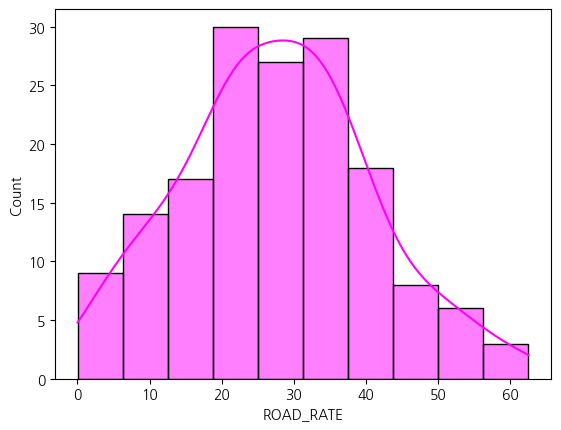

In [196]:
sns.histplot(data=result, x='ROAD_RATE', kde=True,color='magenta')
plt.show()

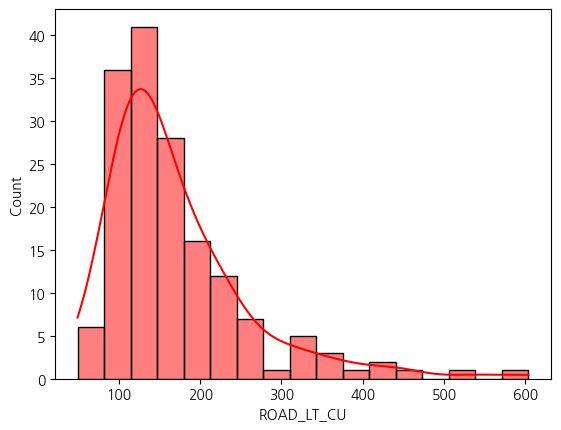

In [198]:
sns.histplot(data=result, x='ROAD_LT_CU', kde=True,color='red')
plt.show()